# Analisi di spettrogrammi audio

In questo notebook viene eseguita un'analisi sugli spettrogrammi di alcuni audio. L'obiettivo è estrarre informazioni utili dagli spettrogrammi e rappresentarle graficamente. 

## Importazione delle librerie necessarie

Si installano e importano le librerie necessarie per l'analisi e la visualizzazione dei dati. 
Oltre a quelle già discusse durante il corso, verranno utilizzate le librerie scipy per l'estrazione di informazioni dagli audio e os per la navigazione all'interno delle directory del computer.

In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Funzioni 

Si andranno a creare le funzioni necessarie per l'analisi.

La prima funzione creata è `wav_to_spectr`, che si occupa di trasformare i file audio in formato .wav in spettrogrammi. 
Per farlo viene passata alla funzione il nome della classe che da cui si desidera estrarre l'immagine. Utilizza delle funzioni di scipy che, come precedentemente detto, ci permettono di estrarre le informazioni necessarie: un array di **frequenze espresse in Hz**, un array con la **durata in secondi** e lo spettrogramma. Infine, restituisce questi valori, indicando da quale file audio sono stati estratti e in quale cartella si trovava quel file.

# Sarebbe da copiare quanto scritto in "modello convolutivo base"... capire cosa fare

In [2]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram[..., tf.newaxis]

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

def get_spectrogram_dataset(dataset):
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

def samplefy(train_ds, dir_label):
    for audio, label in train_ds:
        label_np = label.numpy()
        
        for i in range(len(label_np)):
            if label_names[label_np[i]] == dir_label:
                spectrogram = np.squeeze(audio[i])
                spectrogram = np.log(spectrogram + np.finfo(float).eps)  # aggiungiamo una piccola costante per evitare problemi con log(0)
                return spectrogram, label_names[label_np[i]]

La funzione `plot_spectrograms` racchiude tutti i comandi utili per la visualizzazione dei dati. Quando chiamata, utilizza la funzione precedentemente creata per estrarre le informazioni di quattro diversi audio.

In [3]:
def plot_spectrograms(train_ds):
    spectrogram1, label1 = samplefy(train_ds, 'right')
    spectrogram2, label2 = samplefy(train_ds, 'right')
    spectrogram3, label3 = samplefy(train_ds, 'tree')
    spectrogram4, label4 = samplefy(train_ds, 'tree')
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 8)) # Creiamo subplot 2 x 2
    fig.tight_layout(pad=3.0)  # Aggiunge padding tra subplot
    
    # Primo spettrogramma
    im1 = ax[0, 0].imshow(spectrogram1)
    fig.colorbar(im1, ax=ax[0, 0], format='%+2.0f dB')
    ax[0, 0].set_title(f"Classe: {label1}")
    
    # Secondo spettrogramma
    im2 = ax[0, 1].imshow(spectrogram2)
    fig.colorbar(im2, ax=ax[0, 1], format='%+2.0f dB')
    ax[0, 1].set_title(f"Classe: {label2}")
    
    # Terzo spettrogramma
    im3 = ax[1, 0].imshow(spectrogram3)
    fig.colorbar(im3, ax=ax[1, 0], format='%+2.0f dB')
    ax[1, 0].set_title(f"Classe: {label3}")
    
    # Quarto spettrogramma
    im4 = ax[1, 1].imshow(spectrogram4)
    fig.colorbar(im4, ax=ax[1, 1], format='%+2.0f dB')
    ax[1, 1].set_title(f"Classe: {label4}")

    plt.show()

In [4]:
# importiamo il dataset
train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
)

# creiamo la lista di classi
label_names = train_ds.class_names

#diminuiamo la dimensione e otteniamo il dataset di spettrogrammi
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
train_ds = get_spectrogram_dataset(train_ds)

Found 12933 files belonging to 30 classes.


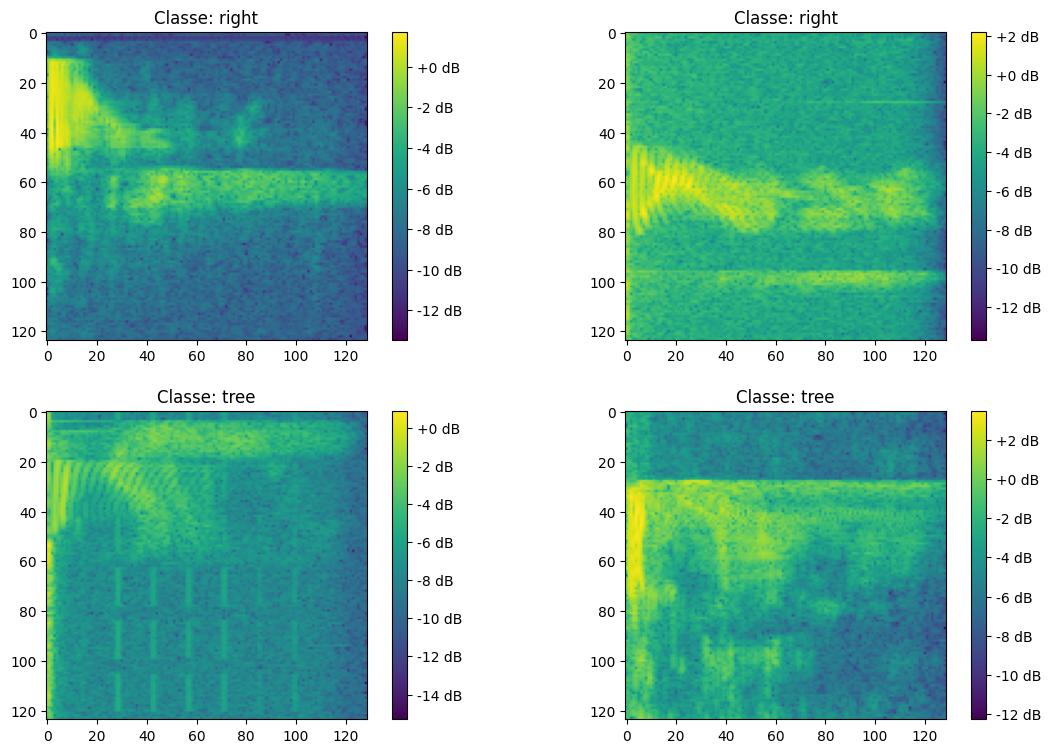

In [5]:
plot_spectrograms(train_ds)

Vengono rappresentati gli spettrogrammi di due etichette diverse. Si può notare, anche ad occhio, come comandi appartenenti ad una stessa etichette abbiano frequenze simili, mentre quelli di classi diverse presentano differenze significative.